## Dependances

In [1]:
import os
import sys
import torch
import av
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, VideoMAEForVideoClassification, TrainingArguments, Trainer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torchsampler import ImbalancedDatasetSampler

# Local dep
project_dir = '/data/konrad/'
sys.path.insert(0, project_dir)
from helpers.helpers import get_indices, load_local_model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-07-04 09:25:35.561180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 09:25:36.214803: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Custom Video Dataset Class
class CalfVideoDataset(Dataset):
    def __init__(self, video_df, processor, max_frames=20, frame_rate = 4, transform = None):
        self.video_df = video_df
        self.processor = processor
        self.max_frames = max_frames
        self.frame_rate = frame_rate
        self.transform = transform

    def __len__(self):
        return len(self.video_df)

    def get_labels(self):
        return self.video_df["target"]

    def __getitem__(self, idx):
        row_video = self.video_df.loc[idx]
        label = torch.tensor(row_video["target"])
        container = av.open(row_video["path"])

        video_stream = container.streams.video[0]

        # Get the duration in time base units
        duration_in_units = video_stream.duration
        
        # Get the time base
        time_base = video_stream.time_base
        
        # Calculate the duration in seconds
        duration_in_seconds = duration_in_units * time_base

        # Sample 16 frames
        fps = int(container.streams.video[0].average_rate)
        seg_len = int(duration_in_seconds) * fps
        sample_rate = min(int(seg_len / self.max_frames) - 1, self.frame_rate)

        # sample max_frames frames
        indices = sample_frame_indices(clip_len=self.max_frames, frame_sample_rate=sample_rate, seg_len=seg_len)
        video = read_video_pyav(container=container, indices=indices)

        # if self.transform:
        #     video = self.transform(video.transpose(0, 3, 1, 2))
        
        inputs = self.processor(list(video), return_tensors="pt")

        return {"pixel_values": inputs["pixel_values"][0], "label": label}

In [3]:
# Define a collate function to handle the feature extractor outputs
def collate_fn(batch):
    # print(torch.stack([item['pixel_values'] for item in batch]).shape)
    return {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch])
    }

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def compute_class_metrics(pred):
    out = {}
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)

    report = classification_report(labels, preds, target_names=id2label.values(), output_dict=True)

    for class_name, metrics in report.items():
        if class_name not in ('accuracy', 'macro avg', 'weighted avg'):
            out[f"{class_name}_precision"] = metrics['precision']
            out[f"{class_name}_recall"] = metrics['recall']
            out[f"{class_name}_f1-score"] = metrics['f1-score']

    out.update({
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    return out
    
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    # start_idx = end_idx - converted_len
    start_idx = 0
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

## Training

In [4]:
csv_path = "train_video_extracted_metadata.csv"
df = pd.read_csv(csv_path, index_col=False)
df = df[~df["label"].isin(['Unknown', 'Diarrhé, Pneumonie'])]
labels = df.label.unique()
label2id = {l:i for i, l in enumerate(labels)}
id2label = {i:l for i, l in enumerate(labels)}
df['target'] = df.apply(lambda row: label2id[row['label']], axis=1)

train_indices, test_indices, valid_indices = get_indices(len(df), train_ratio = 0.8, test_ratio = 0.2, valid_ratio = 0.0)
train_df = df.iloc[train_indices, :].reset_index(drop=True)
test_df = df.iloc[test_indices, :].reset_index(drop=True)

csv_path = "val_video_extracted_metadata.csv"
df = pd.read_csv(csv_path, index_col=False)
df = df[~df["label"].isin(['Unknown', 'Diarrhé, Pneumonie'])]
df['target'] = df.apply(lambda row: label2id[row['label']], axis=1)
valid_df = df.reset_index(drop=True)

# train_transform = v2.Compose([
#     # v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
#     v2.RandomHorizontalFlip(p=0.5),
#     v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
#     # v2.ToDtype(torch.float32, scale=True),
#     # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

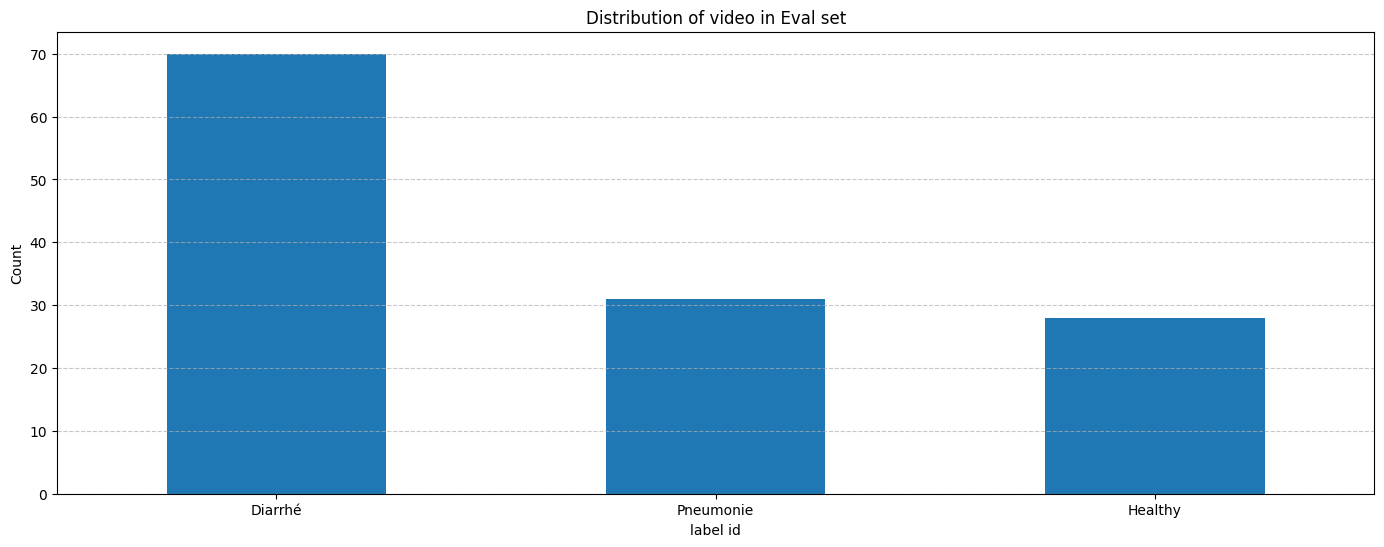

In [6]:
import matplotlib.pyplot as plt

# Count the occurrences of each class
counts = train_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of video in Eval set')
plt.xlabel('label id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset 
        data_collator = self.data_collator

        dataloader_params = {
            "batch_size": self._train_batch_size,
            "collate_fn": data_collator,
            "num_workers": self.args.dataloader_num_workers,
            "pin_memory": self.args.dataloader_pin_memory,
            "persistent_workers": self.args.dataloader_persistent_workers,
            "sampler": ImbalancedDatasetSampler(train_dataset)
        }

        return self.accelerator.prepare(DataLoader(train_dataset, **dataloader_params))

In [7]:
batch_size = 12
clip_len = 16
epochs = 10
lr = 1e-5
frame_rate = 1
patience = 2

model_name = "MCG-NJU/videomae-base"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(model_name, num_labels=len(labels))

train_dataset = CalfVideoDataset(train_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)
test_dataset = CalfVideoDataset(test_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)
valid_dataset = CalfVideoDataset(valid_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir=f'./results/{model_name}',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./logs/{model_name}',
    logging_steps=10,
    evaluation_strategy="epoch",
    metric_for_best_model="f1"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    data_collator = collate_fn,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()
model.save_pretrained(f'./models/{model_name}_{clip_len}_{frame_rate}')

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/data/konrad/jupiter_env/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/data/konrad/jupiter_env/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.049600,1.061360,0.484848,0.306074,0.298137,0.325926
2,0.992700,1.046163,0.515152,0.382353,0.372024,0.403704
3,0.815600,1.068193,0.454545,0.424465,0.433766,0.466667
4,0.683500,0.981969,0.484848,0.368790,0.382850,0.374074
5,0.603300,0.983495,0.484848,0.368790,0.382850,0.374074
6,0.631000,0.981815,0.454545,0.349068,0.357143,0.355556
7,0.561400,0.987206,0.484848,0.426956,0.431078,0.437037
8,0.601500,0.992041,0.454545,0.387427,0.389683,0.403704
9,0.568800,0.979868,0.454545,0.387427,0.389683,0.403704
10,0.547000,0.988113,0.454545,0.387427,0.389683,0.403704


In [6]:
batch_size = 12
clip_len = 16
epochs = 10
lr = 1e-5
frame_rate = 4
patience = 2

model_name = "MCG-NJU/videomae-base"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(model_name, num_labels=len(labels))

train_dataset = CalfVideoDataset(train_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)
test_dataset = CalfVideoDataset(test_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)
valid_dataset = CalfVideoDataset(valid_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir=f'./results/{model_name}',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'./logs/{model_name}',
    logging_steps=10,
    evaluation_strategy="epoch",
    metric_for_best_model="f1"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    data_collator = collate_fn,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()
model.save_pretrained(f'./models/{model_name}_{clip_len}_{frame_rate}')

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/data/konrad/jupiter_env/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/data/konrad/jupiter_env/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.063000,1.053038,0.545455,0.444737,0.461111,0.440741
2,1.004500,1.036918,0.606061,0.511291,0.561404,0.507407
3,0.845000,1.056007,0.424242,0.364307,0.382846,0.385185
4,0.721800,0.982476,0.515152,0.358225,0.386752,0.377778
5,0.624700,0.999337,0.575758,0.531031,0.543860,0.522222
6,0.566700,0.937667,0.666667,0.601852,0.657828,0.577778
7,0.435400,0.939049,0.515152,0.471561,0.481481,0.503704
8,0.325400,0.932951,0.545455,0.495062,0.502193,0.522222
9,0.321800,0.929235,0.515152,0.471561,0.481481,0.503704
10,0.288700,0.916301,0.545455,0.468434,0.484127,0.474074


## Evaluation

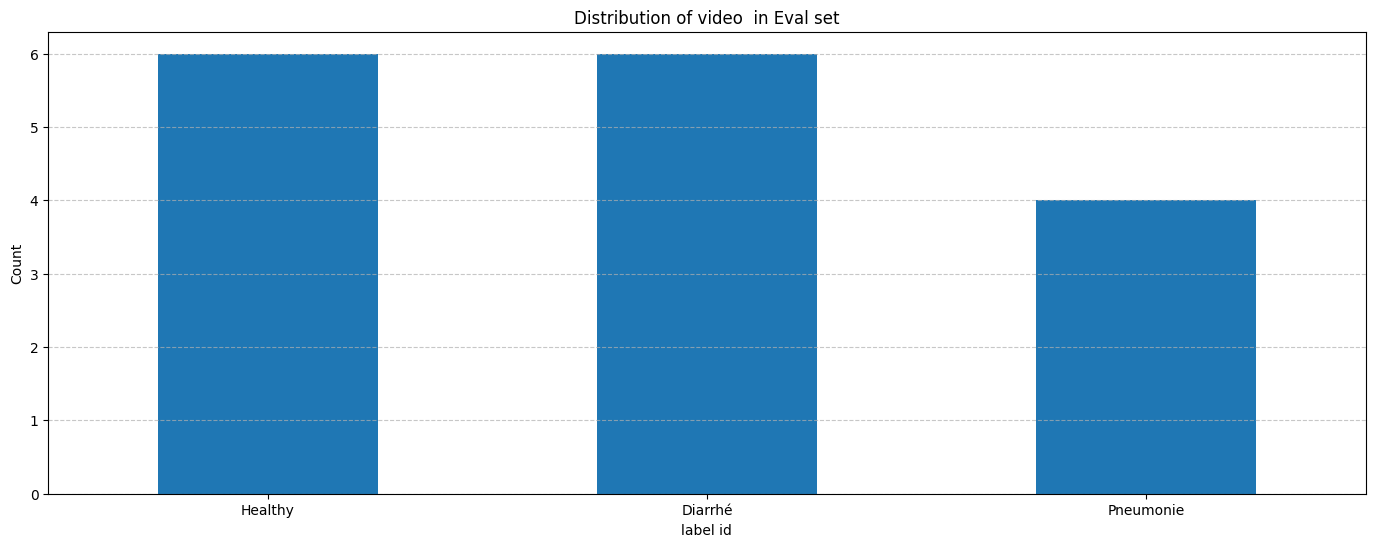

In [13]:
import matplotlib.pyplot as plt

# Count the occurrences of each class
counts = valid_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(17, 6))
counts.plot(kind='bar')
plt.title('Distribution of video in Eval set')
plt.xlabel('label id')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    data_collator = collate_fn,
    compute_metrics=compute_class_metrics
)
eval_results = trainer.evaluate(valid_dataset)

metrics = eval_results
print("Global Metrics:")
print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"F1: {metrics['eval_f1']:.4f}")
print(f"Precision: {metrics['eval_precision']:.4f}")
print(f"Recall: {metrics['eval_recall']:.4f}")

print("\nMetrics per Class:")
print("Pneumonie:")
print(f"F1: {metrics['eval_Pneumonie_f1-score']:.4f}")
print(f"Precision: {metrics['eval_Pneumonie_precision']:.4f}")
print(f"Recall: {metrics['eval_Pneumonie_recall']:.4f}")
print("\nDiarrhé:")
print(f"F1: {metrics['eval_Diarrhé_f1-score']:.4f}")
print(f"Precision: {metrics['eval_Diarrhé_precision']:.4f}")
print(f"Recall: {metrics['eval_Diarrhé_recall']:.4f}")
print("\nHealthy:")
print(f"F1: {metrics['eval_Healthy_f1-score']:.4f}")
print(f"Precision: {metrics['eval_Healthy_precision']:.4f}")
print(f"Recall: {metrics['eval_Healthy_recall']:.4f}")

Global Metrics:
Accuracy: 0.5000
F1: 0.5000
Precision: 0.5000
Recall: 0.5000

Metrics per Class:
Pneumonie:
F1: 0.0000
Precision: 0.0000
Recall: 0.0000

Diarrhé:
F1: 0.5000
Precision: 0.4000
Recall: 0.6667

Healthy:
F1: 0.7273
Precision: 0.8000
Recall: 0.6667


In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    data_collator = collate_fn,
    compute_metrics=compute_class_metrics
)
eval_results = trainer.evaluate(valid_dataset)

metrics = eval_results
print("Global Metrics:")
print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"F1: {metrics['eval_f1']:.4f}")
print(f"Precision: {metrics['eval_precision']:.4f}")
print(f"Recall: {metrics['eval_recall']:.4f}")

print("\nMetrics per Class:")
print("Pneumonie:")
print(f"F1: {metrics['eval_Pneumonie_f1-score']:.4f}")
print(f"Precision: {metrics['eval_Pneumonie_precision']:.4f}")
print(f"Recall: {metrics['eval_Pneumonie_recall']:.4f}")
print("Diarrhé:")
print(f"F1: {metrics['eval_Diarrhé_f1-score']:.4f}")
print(f"Precision: {metrics['eval_Diarrhé_precision']:.4f}")
print(f"Recall: {metrics['eval_Diarrhé_recall']:.4f}")
print("Healthy:")
print(f"F1: {metrics['eval_Healthy_f1-score']:.4f}")
print(f"Precision: {metrics['eval_Healthy_precision']:.4f}")
print(f"Recall: {metrics['eval_Healthy_recall']:.4f}")

Global Metrics:
Accuracy: 0.5000
F1: 0.5000
Precision: 0.5000
Recall: 0.5000

Metrics per Class:
Pneumonie:
F1: 0.0000
Precision: 0.0000
Recall: 0.0000
Diarrhé:
F1: 0.5556
Precision: 0.4167
Recall: 0.8333
Healthy:
F1: 0.6667
Precision: 1.0000
Recall: 0.5000
